In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *
import pandas as pd

In [4]:
#path_to_audio_files = "../acoustic-id-test-data/TEST/"
#path_to_save_csv = "Stratified_Random_Sample_BirdNET_Labels.csv"
path_to_manual_labels = "../AID_ICML_2021/Stratified_Random_Sample_Bird_Labels.csv"

In [ ]:
# generate a list of audiomoths
remove = [18, 19, 21, 28]
am_list = [str(x) for x in range(1,31) if x not in remove]
am_list = ["AM" + x for x in am_list]
am_list.extend(["WWF" + str(x) for x in range(1,6)])
am_list


## Format manual_df 3s

In [ ]:
manual_df = pd.read_csv(path_to_manual_labels)
manual_df

In [ ]:
manual_df = manual_df.sort_values(by=['Folder', 'Clip'])
manual_df.columns = ['FOLDER', 'IN FILE', 'MANUAL ID']
manual_df['MANUAL ID'] = manual_df['MANUAL ID'].map({'y': "bird", 'n': "no bird"})
#manual_df.reset_index(drop=True).to_csv("Stratified_Random_Sample_Peru2019_Manual_Labels_Updated.csv")

In [ ]:
# # check for duplicate clip names
# manual_df.sort_values(by="IN FILE").
# manual_df[manual_df.duplicated(keep=False)].sort_values(by="IN FILE")

## Format manual_df for 10s

In [5]:
manual_df_10s = pd.read_csv(path_to_manual_labels)
manual_df_10s

,Folder,Clip,Bird(s)?
0,WWF5_samples_split,5D2C0D00_5.WAV,y
1,WWF5_samples_split,5D208AE8_13.WAV,n
2,WWF5_samples_split,5D28A2C8_0.WAV,n
3,WWF5_samples_split,5D208AE8_10.WAV,y
4,WWF5_samples_split,5D2C0D00_8.WAV,y
...,...,...,...
7115,AM1_samples_split,20190627_151000_12.WAV,y
7116,AM1_samples_split,20190701_084000_1.WAV,n
7117,AM1_samples_split,20190624_074000_14.WAV,n
7118,AM1_samples_split,20190621_085000_19.WAV,n


In [6]:
manual_df_10s = manual_df_10s.sort_values(by=['Folder', 'Clip'])
manual_df_10s.columns = ['FOLDER', 'IN FILE', 'MANUAL ID']
manual_df_10s['MANUAL ID'] = manual_df_10s['MANUAL ID'].map({'y': "bird", 'n': "no bird"})
manual_df_10s = manual_df_10s[manual_df_10s["MANUAL ID"] != "no bird"]

In [7]:
# split by _ to get the number.extension, then split by . to get the number
manual_df_10s['OFFSET'] = manual_df_10s['IN FILE'].str.rsplit("_").str[-1].str.rsplit(".").str[0]
manual_df_10s['OFFSET'] = manual_df_10s['OFFSET'].astype(float)
manual_df_10s['OFFSET'] = manual_df_10s['OFFSET'].apply(lambda x: x*3)

In [8]:
manual_df_10s['CHANNEL'] = 0
manual_df_10s['CLIP LENGTH'] = 60.0
manual_df_10s['SAMPLE RATE'] = 44100
manual_df_10s['DURATION'] = 3.0

In [9]:
# split by _, remove numbers
manual_df = manual_df_10s.copy()
manual_df["IN FILE"] = manual_df["IN FILE"].str.rsplit("_").str[:-1].apply('_'.join)
manual_df['IN FILE'] = manual_df['IN FILE'].astype(str) + ".WAV"
manual_df

,FOLDER,IN FILE,MANUAL ID,OFFSET,CHANNEL,CLIP LENGTH,SAMPLE RATE,DURATION
1918,AM16_samples_split,20190613_011000.WAV,bird,0.0,0,60.0,44100,3.0
2131,AM16_samples_split,20190613_011000.WAV,bird,3.0,0,60.0,44100,3.0
1953,AM16_samples_split,20190613_011000.WAV,bird,30.0,0,60.0,44100,3.0
1957,AM16_samples_split,20190613_011000.WAV,bird,33.0,0,60.0,44100,3.0
1934,AM16_samples_split,20190613_011000.WAV,bird,36.0,0,60.0,44100,3.0
...,...,...,...,...,...,...,...,...
363,WWF5_samples_split,5D2F0460.WAV,bird,15.0,0,60.0,44100,3.0
63,WWF5_samples_split,5D2F0460.WAV,bird,18.0,0,60.0,44100,3.0
407,WWF5_samples_split,5D2F0460.WAV,bird,21.0,0,60.0,44100,3.0
111,WWF5_samples_split,5D2F0460.WAV,bird,24.0,0,60.0,44100,3.0


## Split dataset into 3s clips

In [ ]:
# splitting dataset into 3s chunks
from pydub import AudioSegment
import os

path_to_audio = "../acoustic-id-test-data/testing/"

# get a list of subdirectories
subfolders = [ f.path for f in os.scandir(path_to_audio) if f.is_dir() ]
   
# iterate through each folder in a directory
for folder in subfolders:
    new_folder = folder + "_split"
    print(new_folder)
    # make a new folder for split files 
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    # iterate through files
    for file in os.listdir(folder):
        # split into 3s clips
        for i in range(20):
            # start time in milliseconds
            t1 = i * 3 * 1000
            # end time in milliseconds
            t2 = (i+1) * 3 * 1000 
            newAudio = AudioSegment.from_wav(folder + "/" + file)
            newAudio = newAudio[t1:t2]
            new_path = new_folder + "/" + file[:-4] + "_" + str(i) + file[-4:] 
            newAudio.export(new_path, format="wav")

## Generate automated labels

In [ ]:
isolation_parameters = {
   "model" : "birdnet",
   "output_path" : "outputs",
   "filetype" : "wav", 
   "num_predictions" : 1,
   "write_to_csv" : False
}

In [ ]:
automated_df = generate_automated_labels(path,isolation_parameters);

In [ ]:
automated_df.to_csv(path_to_save_csv)

## Clean up automated output

In [12]:
# remove no bird labels
manual_df = manual_df[manual_df["MANUAL ID"] != "no bird"]
manual_df

,FOLDER,IN FILE,MANUAL ID,OFFSET,CHANNEL,CLIP LENGTH,SAMPLE RATE,DURATION
1918,AM16_samples,20190613_011000.WAV,bird,0.0,0,60.0,44100,3.0
2131,AM16_samples,20190613_011000.WAV,bird,3.0,0,60.0,44100,3.0
1953,AM16_samples,20190613_011000.WAV,bird,30.0,0,60.0,44100,3.0
1957,AM16_samples,20190613_011000.WAV,bird,33.0,0,60.0,44100,3.0
1934,AM16_samples,20190613_011000.WAV,bird,36.0,0,60.0,44100,3.0
...,...,...,...,...,...,...,...,...
363,WWF5_samples,5D2F0460.WAV,bird,15.0,0,60.0,44100,3.0
63,WWF5_samples,5D2F0460.WAV,bird,18.0,0,60.0,44100,3.0
407,WWF5_samples,5D2F0460.WAV,bird,21.0,0,60.0,44100,3.0
111,WWF5_samples,5D2F0460.WAV,bird,24.0,0,60.0,44100,3.0


Microfaune

In [44]:
# concatenates all of the produced .csv files
import glob
path = r'C:\Users\saman\OneDrive\Documents\GitHub\PyHa\Microfaune_Peru2019_w_conf' 
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
automated_df_micro = pd.concat(df_from_each_file, ignore_index=True)

TweetyNET

In [45]:
# concatenates all of the produced .csv files
import glob
path = r'C:\Users\saman\OneDrive\Documents\GitHub\PyHa\TweetyNet_Peru2019_w_conf' 
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
automated_df_tweety = pd.concat(df_from_each_file, ignore_index=True)

BirdNET

In [46]:
# concatenates all of the produced .csv files
import glob
path = r'C:\Users\saman\OneDrive\Documents\GitHub\PyHa\BirdNET_Peru2019_w_conf' 
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
automated_df_birdnet = pd.concat(df_from_each_file, ignore_index=True)
# change from species-specific to bird
automated_df_birdnet["MANUAL ID"] = "bird"


In [ ]:
# check the intersection of annotations
inner_merged = pd.merge(automated_df, manual_df, on=["IN FILE"])
inner_merged

In [ ]:
# check the union of annotations
outer_merged = pd.merge(automated_df, manual_df, how="outer", on=["IN FILE"])
outer_merged

# Dataset Statistics

In [ ]:
# convert to csvs
manual_df.to_csv("SRSPeru_Manual_Labels.csv")
automated_df_micro.to_csv("SRSPeru_Microfaune_Labels.csv")
automated_df_birdnet.to_csv("SRSPeru_BirdNET_Labels.csv")
automated_df_tweety.to_csv("SRSPeru_TweetyNET_Labels.csv")

In [50]:
display(automated_df_micro)
display(automated_df_birdnet)
display(automated_df_tweety)

,Unnamed: 0.1,Unnamed: 0,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID,CONFIDENCE
0,0,0,AM10_samples,20190622_210000.WAV,0,60.0,44100,0.0,3.0,bird,1.000000
1,1,1,AM10_samples,20190622_210000.WAV,0,60.0,44100,3.0,3.0,bird,0.905934
2,2,2,AM10_samples,20190622_210000.WAV,0,60.0,44100,6.0,3.0,bird,0.965558
3,3,3,AM10_samples,20190621_124000.WAV,0,60.0,44100,12.0,3.0,bird,0.603111
4,4,4,AM10_samples,20190621_124000.WAV,0,60.0,44100,15.0,3.0,bird,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1414,1414,32,WWF5_samples,5D2F0460.WAV,0,60.0,44100,27.0,3.0,bird,0.380799
1415,1415,33,WWF5_samples,5D2F0460.WAV,0,60.0,44100,30.0,3.0,bird,0.821059
1416,1416,34,WWF5_samples,5D2F0460.WAV,0,60.0,44100,42.0,3.0,bird,0.989643
1417,1417,35,WWF5_samples,5D2F0460.WAV,0,60.0,44100,45.0,3.0,bird,1.000000


,Unnamed: 0.1,Unnamed: 0,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,0,0,AM10_samples,20190626_234000.WAV,60.0,0,0.0,3.0,48000,Lophostrix cristata,0.027209
1,1,1,AM10_samples,20190626_234000.WAV,60.0,0,3.0,3.0,48000,Ptilinopus occipitalis,0.024889
2,2,2,AM10_samples,20190626_234000.WAV,60.0,0,6.0,3.0,48000,Capito wallacei,0.208977
3,3,3,AM10_samples,20190626_234000.WAV,60.0,0,9.0,3.0,48000,Ptilinopus occipitalis,0.037832
4,4,4,AM10_samples,20190626_234000.WAV,60.0,0,12.0,3.0,48000,Capito wallacei,0.085857
...,...,...,...,...,...,...,...,...,...,...,...
14215,14215,475,WWF5_samples,5D2F0460.WAV,60.0,0,45.0,3.0,48000,Ptilinopus occipitalis,0.009471
14216,14216,476,WWF5_samples,5D2F0460.WAV,60.0,0,48.0,3.0,48000,Sciaphylax hemimelaena,0.070114
14217,14217,477,WWF5_samples,5D2F0460.WAV,60.0,0,51.0,3.0,48000,Otus scops,0.013611
14218,14218,478,WWF5_samples,5D2F0460.WAV,60.0,0,54.0,3.0,48000,Urosphena squameiceps,0.028108


,Unnamed: 0.1,Unnamed: 0,OFFSET,DURATION,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,0,0,15.255814,0.069767,AM10_samples,20190623_222000.WAV,0,60.0,44100,bird,0.828130
1,1,1,15.953488,0.046512,AM10_samples,20190623_222000.WAV,0,60.0,44100,bird,0.821336
2,2,2,20.581395,0.186047,AM10_samples,20190623_222000.WAV,0,60.0,44100,bird,0.903865
3,3,3,21.046512,0.046512,AM10_samples,20190623_222000.WAV,0,60.0,44100,bird,0.848652
4,4,4,22.744186,0.046512,AM10_samples,20190623_222000.WAV,0,60.0,44100,bird,0.849333
...,...,...,...,...,...,...,...,...,...,...,...
4243,4243,148,45.186047,0.162791,WWF5_samples,5D29ED40.WAV,0,60.0,44100,bird,0.750407
4244,4244,149,45.395349,0.139535,WWF5_samples,5D29ED40.WAV,0,60.0,44100,bird,0.713340
4245,4245,150,4.325581,0.162791,WWF5_samples,5D2F0460.WAV,0,60.0,44100,bird,1.000000
4246,4246,151,8.116279,0.069767,WWF5_samples,5D2F0460.WAV,0,60.0,44100,bird,0.904887


In [53]:
automated_df_tweety = annotation_chunker(automated_df_tweety,3)

In [34]:
statistics_df_birdnet = automated_labeling_statistics(automated_df_birdnet, manual_df, stats_type="general")
statistics_df_micro = automated_labeling_statistics(automated_df_micro, manual_df, stats_type="general")
statistics_df_tweety = automated_labeling_statistics(automated_df_tweety, manual_df, stats_type="general")

Something went wrong with: 20190626_234000.WAV
list index out of range
Something went wrong with: 20190627_071000.WAV
list index out of range
Something went wrong with: 20190622_210000.WAV
list index out of range
Something went wrong with: 20190623_222000.WAV
list index out of range
Something went wrong with: 20190627_073000.WAV
list index out of range
Something went wrong with: 20190621_164000.WAV
list index out of range
Something went wrong with: 20190624_154000.WAV
list index out of range
Something went wrong with: 20190628_073000.WAV
list index out of range
Something went wrong with: 20190625_144000.WAV
list index out of range
Something went wrong with: 20190621_180000.WAV
list index out of range
Something went wrong with: 20190621_124000.WAV
list index out of range
Something went wrong with: 20190613_041000.WAV
list index out of range
Something went wrong with: 20190618_231000.WAV
list index out of range
Something went wrong with: 20190626_172000.WAV
list index out of range
Someth

Something went wrong with: 20190614_174000.WAV
list index out of range
Something went wrong with: 20190620_113000.WAV
list index out of range
Something went wrong with: 20190616_081000.WAV
list index out of range
Something went wrong with: 20190623_190000.WAV
list index out of range
Something went wrong with: 20190626_012000.WAV
list index out of range
Something went wrong with: 20190616_133000.WAV
list index out of range
Something went wrong with: 20190617_055000.WAV
list index out of range
Something went wrong with: 20190621_073000.WAV
list index out of range
Something went wrong with: 20190614_000000.WAV
list index out of range
Something went wrong with: 20190624_150000.WAV
list index out of range
Something went wrong with: 20190613_155000.WAV
list index out of range
Something went wrong with: 20190619_172000.WAV
list index out of range
Something went wrong with: 20190629_063000.WAV
list index out of range
Something went wrong with: 20190626_011000.WAV
list index out of range
Someth

Something went wrong with: 20190623_151000.WAV
list index out of range
Something went wrong with: 20190624_172000.WAV
list index out of range
Something went wrong with: 20190703_214000.WAV
list index out of range
Something went wrong with: 20190623_051000.WAV
list index out of range
Something went wrong with: 20190622_234000.WAV
list index out of range
Something went wrong with: 20190613_001000.WAV
list index out of range
Something went wrong with: 20190627_021000.WAV
list index out of range
Something went wrong with: 20190702_023000.WAV
list index out of range
Something went wrong with: 20190628_132000.WAV
list index out of range
Something went wrong with: 20190620_011000.WAV
list index out of range
Something went wrong with: 20190620_123000.WAV
list index out of range
Something went wrong with: 20190627_011000.WAV
list index out of range
Something went wrong with: 20190704_162000.WAV
list index out of range
Something went wrong with: 20190623_123000.WAV
list index out of range
Someth

Something went wrong with: 20190617_055000.WAV
list index out of range
Something went wrong with: 20190613_155000.WAV
list index out of range
Something went wrong with: 20190619_172000.WAV
list index out of range
Something went wrong with: 20190629_063000.WAV
list index out of range
Something went wrong with: 20190626_011000.WAV
list index out of range
Something went wrong with: 20190613_040000.WAV
list index out of range
Something went wrong with: 20190614_100000.WAV
list index out of range
Something went wrong with: 20190618_051000.WAV
list index out of range
Error calculating statistics, likely due
        to zero division, setting values to zero
Something went wrong with: 20190626_063000.WAV
list index out of range
Something went wrong with: 20190616_062000.WAV
list index out of range
Something went wrong with: 20190618_033000.WAV
list index out of range
Something went wrong with: 20190624_235000.WAV
list index out of range
Something went wrong with: 20190619_153000.WAV
list index 

Something went wrong with: 20190629_012000.WAV
list index out of range
Something went wrong with: 20190627_041000.WAV
list index out of range
Something went wrong with: 20190613_012000.WAV
list index out of range
Something went wrong with: 20190629_002000.WAV
list index out of range
Something went wrong with: 20190704_182000.WAV
list index out of range
Something went wrong with: 20190618_063000.WAV
list index out of range
Something went wrong with: 20190616_012000.WAV
list index out of range
Something went wrong with: 20190615_050000.WAV
list index out of range
Something went wrong with: 20190705_145000.WAV
list index out of range
Something went wrong with: 20190705_112000.WAV
list index out of range
Something went wrong with: 20190704_221000.WAV
list index out of range
Something went wrong with: 20190622_014000.WAV
list index out of range
Something went wrong with: 20190623_033000.WAV
list index out of range
Something went wrong with: 20190616_000000.WAV
list index out of range
Error 

Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Something went wrong with: 20190706_062000.WAV
list index out of range
Error calculating statistics, likely due
        to zero division, setting values to zero
Error calculating statistics, likely due
        to zero division, setting values to zero
Something went wrong with: 20190622_080000.WAV
list index out of range
Something went wrong with: 20190613_084000.WAV
list index out of range
Something went wrong with: 20190612_133000.WAV
list index out of range
Something went wrong with: 20190701_073000.WAV
list index out of range
Something went wrong with: 20190703_212000.WAV
list index out of range
Something went wrong with: 20190622_060000.WAV
list index out of range
Something went wrong with: 20190705_232000.WAV
list index out of range
Something went wrong with: 20190701_050000.WAV
list index out of range
S

In [35]:
display(global_dataset_statistics(statistics_df_micro).style.set_caption("Microfaune Annotations"))
display(global_dataset_statistics(statistics_df_birdnet).style.set_caption("BirdNET Annotations"))
display(global_dataset_statistics(statistics_df_tweety).style.set_caption("TweetyNET Annotations"))

,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.850606,0.396985,0.541328,0.371110


,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.512500,1.000000,0.677686,0.512500


,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.698314,0.319919,0.438807,0.281071


In [32]:
display(global_dataset_statistics(statistics_df_micro).style.set_caption("Microfaune Annotations"))
display(global_dataset_statistics(statistics_df_birdnet).style.set_caption("BirdNET Annotations"))
display(global_dataset_statistics(statistics_df_tweety).style.set_caption("TweetyNET Annotations"))

,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.850606,0.396985,0.541328,0.371110


,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.512500,1.000000,0.677686,0.512500


,MANUAL ID,PRECISION,RECALL,F1,Global IoU
0,bird,0.748549,0.043105,0.081517,0.042490


# Cleaning up for ROC Curves

In [49]:
manual_df = pd.read_csv("./SRSPeru_Manual_Labels.csv")
def undo2(x):
    return x.split("_")[0] + "_" + x.split("_")[1]

manual_df["FOLDER"] = manual_df["FOLDER"].apply(undo2)
manual_df

,Unnamed: 0,FOLDER,IN FILE,MANUAL ID,OFFSET,DURATION,CLIP LENGTH,CHANNEL,SAMPLE RATE
0,1918,AM16_samples,20190613_011000.WAV,bird,0.0,3.0,60.0,0,44100
1,2131,AM16_samples,20190613_011000.WAV,bird,3.0,3.0,60.0,0,44100
2,1953,AM16_samples,20190613_011000.WAV,bird,30.0,3.0,60.0,0,44100
3,1957,AM16_samples,20190613_011000.WAV,bird,33.0,3.0,60.0,0,44100
4,1934,AM16_samples,20190613_011000.WAV,bird,36.0,3.0,60.0,0,44100
...,...,...,...,...,...,...,...,...,...
3108,363,WWF5_samples,5D2F0460.WAV,bird,15.0,3.0,60.0,0,44100
3109,63,WWF5_samples,5D2F0460.WAV,bird,18.0,3.0,60.0,0,44100
3110,407,WWF5_samples,5D2F0460.WAV,bird,21.0,3.0,60.0,0,44100
3111,111,WWF5_samples,5D2F0460.WAV,bird,24.0,3.0,60.0,0,44100


In [48]:
automated_df_micro = pd.read_csv("SRSPeru_Microfaune_Labels.csv")
automated_df_birdnet = pd.read_csv("SRSPeru_BirdNET_Labels.csv")
automated_df_tweety = pd.read_csv("SRSPeru_TweetyNet_Labels.csv")

def undo(x):
    return x.split("/")[-2]
automated_df_micro["FOLDER"] = automated_df_micro["FOLDER"].apply(undo)
automated_df_tweety["FOLDER"] = automated_df_tweety["FOLDER"].apply(undo)
automated_df_birdnet["FOLDER"] = automated_df_birdnet["FOLDER"].apply(undo)
#automated_df_birdnet

1900    AM6_samples20190611_230000.WAV
1901    AM6_samples20190611_230000.WAV
1902    AM6_samples20190611_230000.WAV
1903    AM6_samples20190611_230000.WAV
1904    AM6_samples20190611_230000.WAV
                     ...              
2155          WWF1_samples5D2F1018.WAV
2156          WWF1_samples5D2F1018.WAV
2157          WWF1_samples5D2F1018.WAV
2158          WWF1_samples5D2F1018.WAV
2159          WWF1_samples5D2F1018.WAV
Name: path, Length: 2640, dtype: object
0       AM10_samples20190622_210000.WAV
1       AM10_samples20190622_210000.WAV
2       AM10_samples20190622_210000.WAV
3       AM10_samples20190621_124000.WAV
4       AM10_samples20190621_124000.WAV
                     ...               
1414           WWF5_samples5D2F0460.WAV
1415           WWF5_samples5D2F0460.WAV
1416           WWF5_samples5D2F0460.WAV
1417           WWF5_samples5D2F0460.WAV
1418           WWF5_samples5D2F0460.WAV
Name: path, Length: 1419, dtype: object
126
126


C:\Users\saman\OneDrive\Documents\GitHub\PyHa\PyHa\annotation_post_processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"]
C:\Users\saman\OneDrive\Documents\GitHub\PyHa\PyHa\annotation_post_processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"]


154800.0 154800.0
target 2580
manual df 2580
confidence 2580
automated df 2580
1900    AM6_samples20190611_230000.WAV
1901    AM6_samples20190611_230000.WAV
1902    AM6_samples20190611_230000.WAV
1903    AM6_samples20190611_230000.WAV
1904    AM6_samples20190611_230000.WAV
                     ...              
2155          WWF1_samples5D2F1018.WAV
2156          WWF1_samples5D2F1018.WAV
2157          WWF1_samples5D2F1018.WAV
2158          WWF1_samples5D2F1018.WAV
2159          WWF1_samples5D2F1018.WAV
Name: path, Length: 2640, dtype: object
0        AM10_samples20190626_234000.WAV
1        AM10_samples20190626_234000.WAV
2        AM10_samples20190626_234000.WAV
3        AM10_samples20190626_234000.WAV
4        AM10_samples20190626_234000.WAV
                      ...               
14215           WWF5_samples5D2F0460.WAV
14216           WWF5_samples5D2F0460.WAV
14217           WWF5_samples5D2F0460.WAV
14218           WWF5_samples5D2F0460.WAV
14219           WWF5_samples5D2F0460.WAV
N

C:\Users\saman\OneDrive\Documents\GitHub\PyHa\PyHa\annotation_post_processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"]


158400.0 158400.0
target 2640
manual df 2640
confidence 2640
automated df 2640
1900    AM6_samples20190611_230000.WAV
1901    AM6_samples20190611_230000.WAV
1902    AM6_samples20190611_230000.WAV
1903    AM6_samples20190611_230000.WAV
1904    AM6_samples20190611_230000.WAV
                     ...              
2155          WWF1_samples5D2F1018.WAV
2156          WWF1_samples5D2F1018.WAV
2157          WWF1_samples5D2F1018.WAV
2158          WWF1_samples5D2F1018.WAV
2159          WWF1_samples5D2F1018.WAV
Name: path, Length: 2640, dtype: object
0       AM10_samples20190623_222000.WAV
1       AM10_samples20190623_222000.WAV
2       AM10_samples20190623_222000.WAV
3       AM10_samples20190623_222000.WAV
4       AM10_samples20190621_180000.WAV
                     ...               
2411           WWF5_samples5D29ED40.WAV
2412           WWF5_samples5D29ED40.WAV
2413           WWF5_samples5D2F0460.WAV
2414           WWF5_samples5D2F0460.WAV
2415           WWF5_samples5D2F0460.WAV
Name: path, 

C:\Users\saman\OneDrive\Documents\GitHub\PyHa\PyHa\annotation_post_processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"]
C:\Users\saman\OneDrive\Documents\GitHub\PyHa\PyHa\annotation_post_processing.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"]


114000.0 114000.0
target 1900
manual df 1900
confidence 1900
automated df 1900


0.5882345929508744

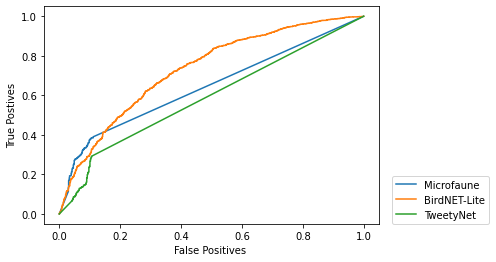

In [113]:
generate_ROC_curves(automated_df_micro, manual_df,label="Microfaune", chunk_length = 3)
generate_ROC_curves(automated_df_birdnet, manual_df, label="BirdNET-Lite", chunk_length = 3)
generate_ROC_curves(automated_df_tweety, manual_df, label="TweetyNet", chunk_length = 3)